In [7]:
import pandas as pd
import numpy as np

In [8]:
# Read the data
data = pd.read_csv(r'C:\Users\vinee\OneDrive\Desktop\projects\BondYeild_Prediction\normalized_bonddata.csv')
data

,DATE,FF,INDPRO,CPI,VIX,DGS10
0,2000-01-01,0.832049,0.660264,0.250000,0.248763,6.66
1,2000-02-01,0.875193,0.653061,0.258278,0.256376,6.52
2,2000-03-01,0.893683,0.658463,0.306291,0.239627,6.26
3,2000-04-01,0.919877,0.671369,0.276490,0.324134,5.99
4,2000-05-01,0.958398,0.661465,0.294702,0.309098,6.44
...,...,...,...,...,...,...
291,2024-04-01,0.813559,0.493697,0.500000,0.114389,4.54
292,2024-05-01,0.813559,0.523109,0.465232,0.055767,4.48
293,2024-06-01,0.813559,0.542617,0.443709,0.048344,4.31
294,2024-07-01,0.813559,0.493998,0.432119,0.080700,4.25


In [9]:
# converting date to datetime and set as index
data['DATE'] = pd.to_datetime(data['DATE'])
data = data.set_index('DATE')

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 296 entries, 2000-01-01 to 2024-08-01
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FF      296 non-null    float64
 1   INDPRO  296 non-null    float64
 2   CPI     296 non-null    float64
 3   VIX     296 non-null    float64
 4   DGS10   296 non-null    float64
dtypes: float64(5)
memory usage: 13.9 KB


In [11]:
import matplotlib.pyplot as plt

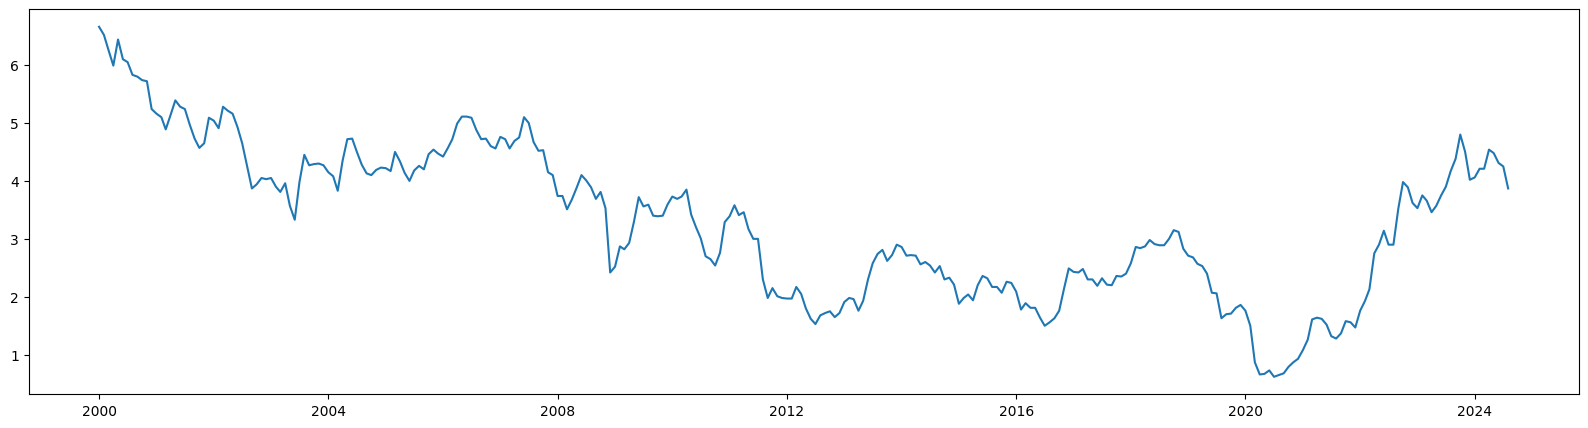

In [12]:
#plot the data
plt.figure(figsize=(20,5))
plt.plot(data['DGS10'])

In [13]:
import seaborn as sns

<Axes: >

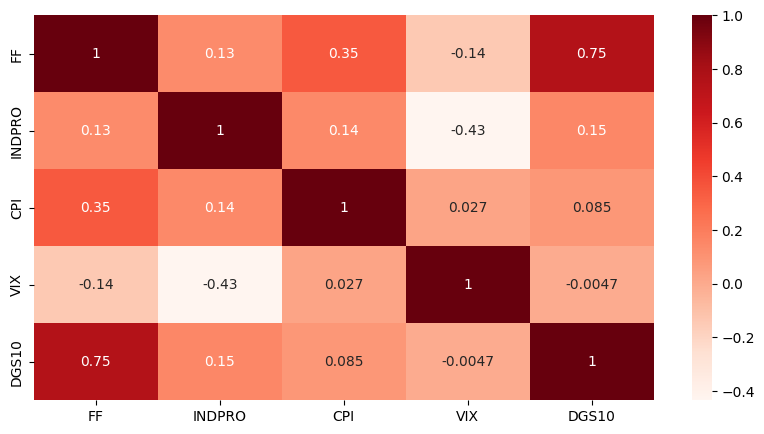

In [14]:
# plotting the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(data.corr(), annot=True, cmap='Reds')


Checking for the stationary 


In [15]:
# import the ADF test
from statsmodels.tsa.stattools import adfuller

# creating a function that returns the necessary metrics to test stationarity
def test_stationarity(timeseries):
    dftest_initial = adfuller(timeseries)
    dfoutput_initial = pd.Series(dftest_initial[0:4], index=['Statistical Test', 'p-value','#Lags used', 'Number of observations'])

    for key, value in dftest_initial[4].items():
        dfoutput_initial['Critical value '+ key] = value

    print(dfoutput_initial)


In [16]:
test_stationarity(data['DGS10'])

Statistical Test           -2.455048
p-value                     0.126798
#Lags used                  2.000000
Number of observations    293.000000
Critical value 1%          -3.452867
Critical value 5%          -2.871455
Critical value 10%         -2.572053
dtype: float64


In [17]:
test_stationarity(data['DGS10'].diff().dropna())

Statistical Test         -1.179213e+01
p-value                   9.769699e-22
#Lags used                1.000000e+00
Number of observations    2.930000e+02
Critical value 1%        -3.452867e+00
Critical value 5%        -2.871455e+00
Critical value 10%       -2.572053e+00
dtype: float64


Decomposing the original time series

Text(0.5, 1.0, 'residuals')

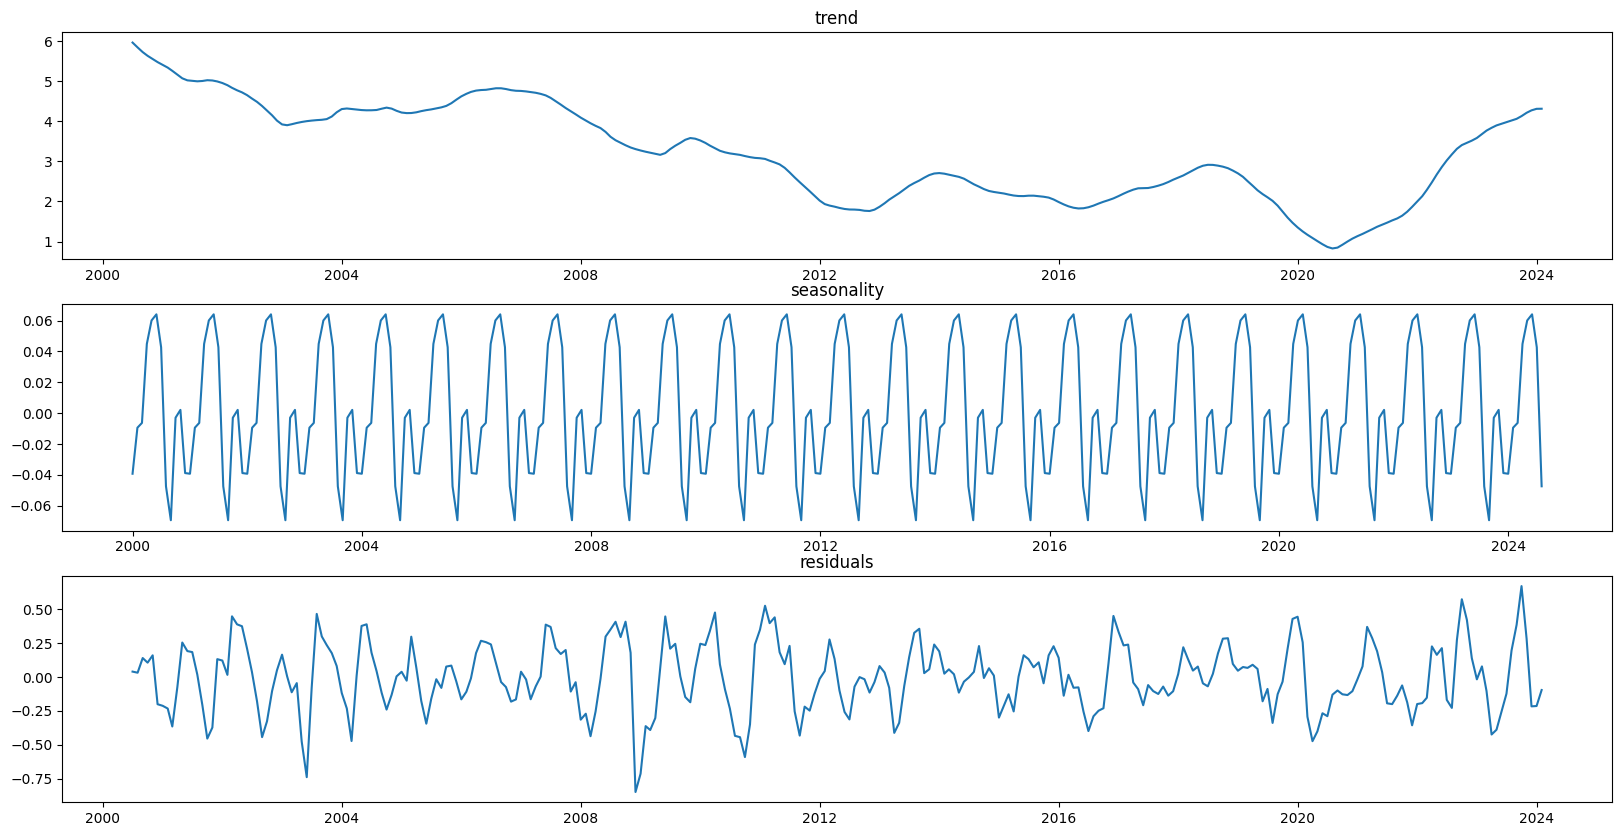

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series into its trend, seasonal and residual components
result_decompose = seasonal_decompose(data['DGS10'], model='additive')
trend = result_decompose.trend
seasonal = result_decompose.seasonal
residuals = result_decompose.resid

# Plot every component
plt.figure(figsize=(20,10))

plt.subplot(311)
plt.plot(trend)
plt.title('trend')

plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')

plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')

In [20]:
# we will forecast for last 4 years from 2020 to 2024 i.e, 56 data points

testing_timeframe = 56
train = data[:-testing_timeframe]
test = data[-testing_timeframe:]
print('training set (past date): ', len(train))
print('test set (days to be forecasted ahead):', len(test))

training set (past date):  240
test set (days to be forecasted ahead): 56


ACF and PACF plots


In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# function that returns the ACF and PACF plots
def autocorrelation_plot(timeseries, description, n_lags):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plot_acf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.subplot(122)
    plot_pacf(timeseries, ax=plt.gca(), lags=n_lags)
    plt.title('Partial Autocorrelation ({})'.format(description))
    plt.xlabel('Number of lags')
    plt.ylabel('correlation')
    plt.show()

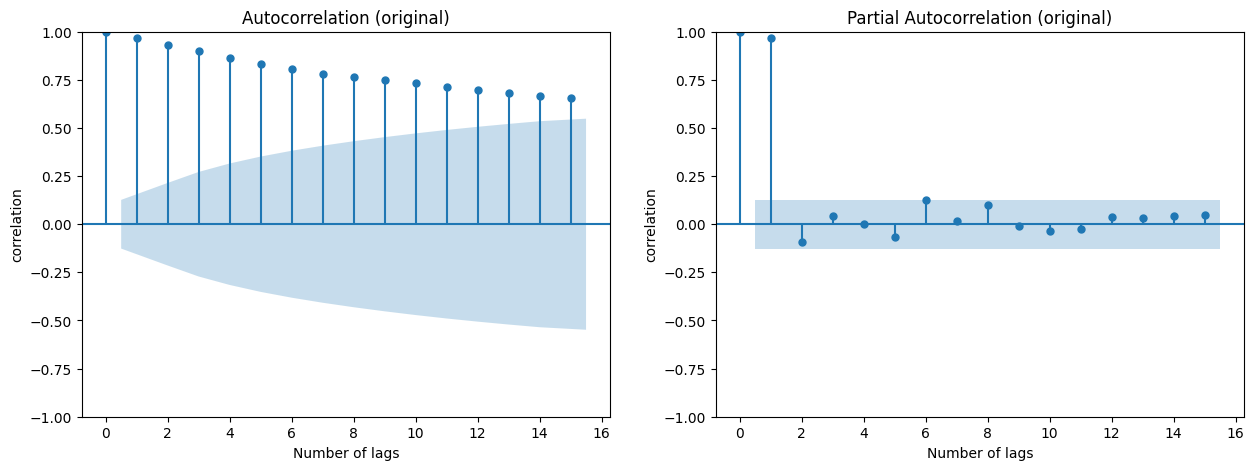

In [23]:
autocorrelation_plot(train['DGS10'], 'original', 15)

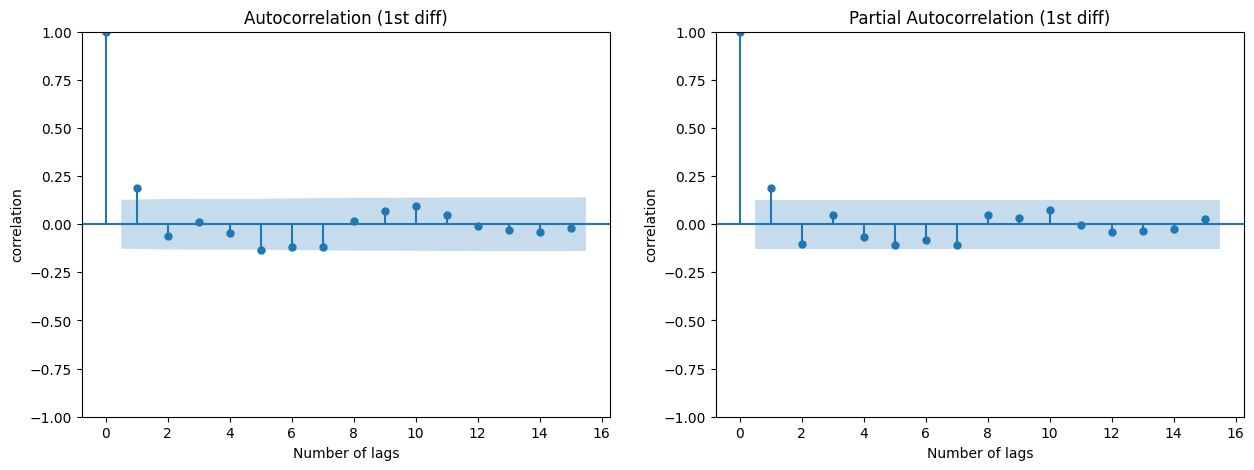

In [24]:
autocorrelation_plot(train['DGS10'].diff().dropna(), '1st diff', 15)

p,d,q = (1,1,1)

Training the ARIMA Model

c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  DGS10   No. Observations:                  240
Model:               SARIMAX(1, 1, 1)   Log Likelihood                  38.959
Date:                Thu, 07 Nov 2024   AIC                            -71.918
Time:                        03:12:57   BIC                            -61.489
Sample:                    01-01-2000   HQIC                           -67.715
                         - 12-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2397      0.250     -0.958      0.338      -0.730       0.251
ma.L1          0.4617      0.235      1.967      0.049       0.002       0.922
sigma2         0.0422      0.003     15.091      0.0

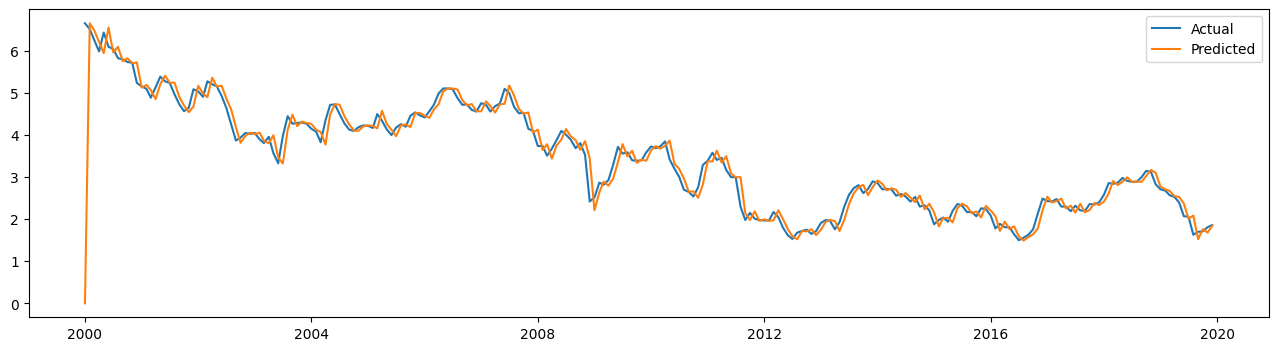

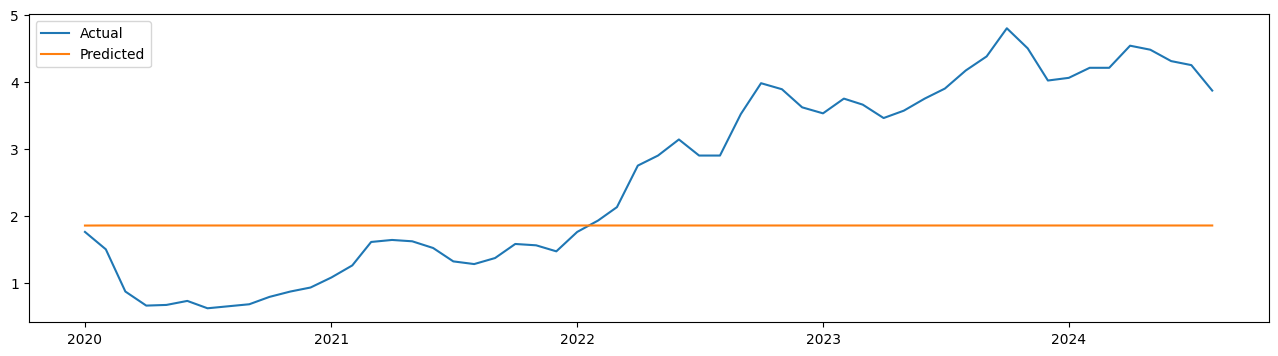

In [25]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# create and fit the model
model_fit = SARIMAX(train['DGS10'], order= (1,1,1)).fit()

print(model_fit.summary())
print('\n')


# creating forecasts on training set
forecasts_on_train = model_fit.predict()

# creating forecasts on test set
forecasts_on_test = model_fit.forecast(len(test))

# calculate the root mean squared error
RMSE = np.sqrt(mean_squared_error(test['DGS10'], forecasts_on_test))

print('AIC: ', model_fit.aic)
print('RMSE: ', RMSE)

#plotting the forecasts

plt.figure(figsize=(16,4))
plt.plot(train['DGS10'], label='Actual')
plt.plot(forecasts_on_train, label='Predicted')
plt.legend()

# on test data
plt.figure(figsize=(16,4))
plt.plot(test['DGS10'], label='Actual')
plt.plot(forecasts_on_test, label='Predicted')
plt.legend()

SARIMA model, S=12 

c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              DGS10   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  18.855
Date:                            Thu, 07 Nov 2024   AIC                            -27.709
Time:                                    03:30:13   BIC                            -10.585
Sample:                                01-01-2000   HQIC                           -20.799
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2670      0.259     -1.031      0.303      -0.775       0.241
ma.L1          0.4733      0.243   

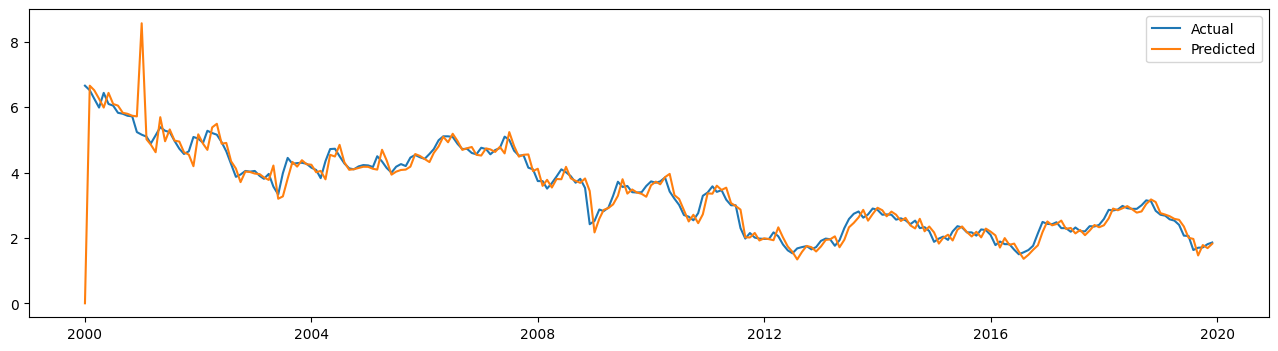

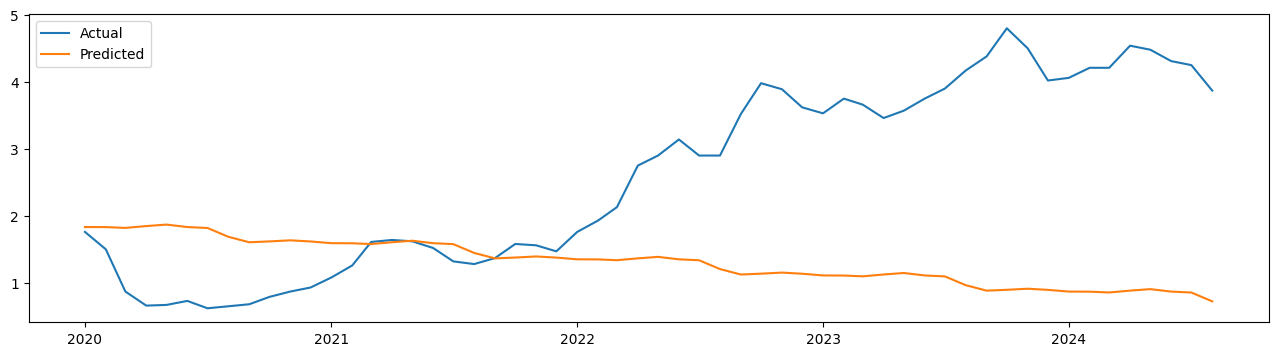

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# fitting the model
model_fit = SARIMAX(train['DGS10'], order=(1,1,1), seasonal_order=(1,1,1,12)).fit()

print(model_fit.summary())
print('\n')


# creating forecasts on train set
forecasts_on_train = model_fit.predict()

# forecasts on test set
forecasts_on_test = model_fit.forecast(len(test))

# RMSE
RMSE = np.sqrt(mean_squared_error(test['DGS10'], forecasts_on_test))

# AIC and RMSE
print('AIC: ', model_fit.aic)
print('RMSE: ', RMSE)

#plotting the forecasts
plt.figure(figsize=(16,4))
plt.plot(train['DGS10'], label='Actual')
plt.plot(forecasts_on_train, label='Predicted')
plt.legend()

# test data
plt.figure(figsize=(16,4))
plt.plot(test['DGS10'], label='Actual')
plt.plot(forecasts_on_test, label='Predicted')
plt.legend()

Adding exogenous variables

c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\vinee\OneDrive\Desktop\projects\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                              DGS10   No. Observations:                  240
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                  24.487
Date:                            Thu, 07 Nov 2024   AIC                            -30.974
Time:                                    03:39:31   BIC                             -0.150
Sample:                                01-01-2000   HQIC                           -18.536
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
FF            -0.0194      0.584     -0.033      0.973      -1.163       1.124
VIX           -0.5903      0.148   

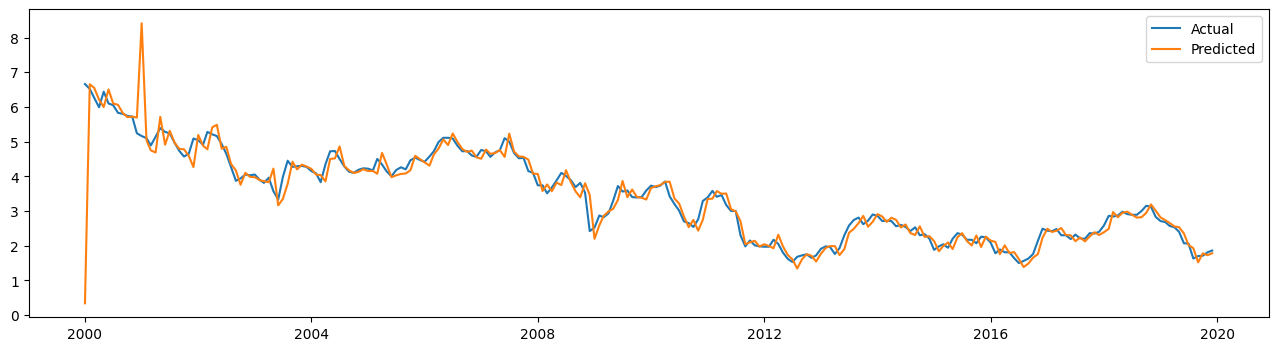

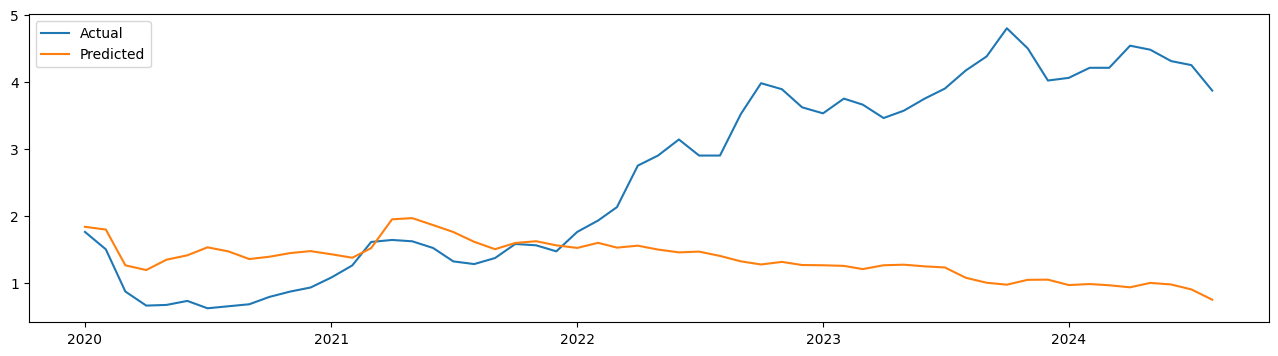

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

#define exogenous variables
exog_train = train[['FF','VIX','INDPRO','CPI']].ffill()
exog_test = test[['FF','VIX','INDPRO','CPI']].ffill()

# fitting the model
model_fit = SARIMAX(train['DGS10'], order = (1,1,1), seasonal_order = (1,1,1,12),exog = exog_train).fit()

print(model_fit.summary())
print('\n')

#train set
forecasts_on_train = model_fit.predict()

#test set
forecasts_on_test  = model_fit.forecast(len(test), exog = exog_test)

RMSE = np.sqrt(mean_squared_error(test['DGS10'], forecasts_on_test))

print('AIC: ', model_fit.aic)
print('RMSE: ', RMSE)


# on train data
plt.figure(figsize=(16,4))
plt.plot(train['DGS10'], label="Actual")
plt.plot(forecasts_on_train, label="Predicted")
plt.legend()

# on test data
plt.figure(figsize=(16,4))
plt.plot(test['DGS10'], label="Actual")
plt.plot(forecasts_on_test, label="Predicted")
plt.legend()